In [2]:
import torch
from torch import nn
from torch.nn import init
import torch.utils.data as data_utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import heapq

In [3]:
if torch.cuda.is_available():
    print("GPU Avail", torch.version.cuda)

GPU Avail 11.0


In [4]:
dataset = np.loadtxt("./ml-1m/ratings.dat",delimiter='::',dtype=int)[:,[0,1,3]]
N_USERS = np.max(dataset[:,0])
N_ITEMS = np.max(dataset[:,1])

number of items:  3952
number of flows:  1000209
avg of S(x):  253.0
parameter phi:  0.00025
parameter epsilon should less than or equal phi
sketch belongs to half of the stream


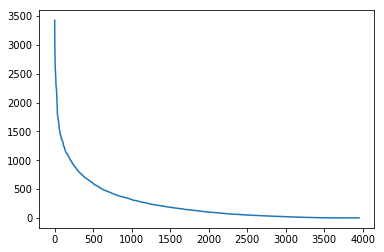

In [5]:
def veiwData(dataset):
    n_users  = np.max(dataset[:,0])
    n_items  = np.max(dataset[:,1])
    avgS     = round(len(dataset) / n_items, 0)
    itemFreq = [0 for x in range(n_items)]
    for record in dataset:
        itemFreq[record[1]-1] += 1
    realHH = set()
    for i,n in enumerate(itemFreq):
        if n >= avgS:
            realHH.add(i+1)
    itemFreq.sort(reverse=True)
    plt.plot(range(len(itemFreq)), itemFreq)
    print("number of items: ", n_items)
    print("number of flows: ", len(dataset))
    print("avg of S(x): ", avgS)
    print("parameter phi: ", round(1 / n_items, 5))
    print("parameter epsilon should less than or equal phi")
    print("sketch belongs to half of the stream")
    return realHH

realHH = veiwData(dataset)

In [6]:
users = pd.read_table("./ml-1m/users.dat", sep = '::', header = None, engine = 'python').iloc[:,0].values
movies = pd.read_table("./ml-1m/movies.dat", sep = '::', header = None, engine = 'python').iloc[:,0].values

In [7]:
# training data
n_negatives = 4  ## 1正例对应n个负例 ##
users_items = np.zeros((N_USERS+1, N_ITEMS+1), dtype = np.int8)  # 混淆矩阵
user_input, item_input, labels = [],[],[]  # x1 x2 -> y
for u in range(dataset.shape[0]):   # 评分数据集隐式化
    users_items[dataset[u][0], dataset[u][1]] = 1
uipositives = list() # 作为测试集的交互正例
for i in range(N_USERS+1):
    if i==0: 
        continue
    uitems = dataset[dataset[:,0]==i]
    onepos = uitems[uitems[:,-1]==np.max(uitems),:2][0]
    uipositives.append(onepos)
    users_items[onepos[0], onepos[1]]=0
for uno, uitems in enumerate(users_items):
    if uno == 0:
        continue
    positives = np.nonzero(uitems)[0]
    n_sample = len(positives) * n_negatives
    negative_items = list(set(range(N_ITEMS+1))^set(positives))
    negatives = np.random.choice(negative_items, n_sample)  # 负采样 -- 不放回
    for i in range(len(positives)): # 正实例
        user_input.append(uno)
        item_input.append(positives[i])
        labels.append(1)
    for j in range(n_sample): # 负实例
        user_input.append(uno)
        item_input.append(negatives[j])
        labels.append(0)
user_input = np.array(user_input)
item_input = np.array(item_input)
labels = np.array(labels)

In [16]:
# test data
utest = list()
itest = list()
for ui in uipositives:
    u = ui[0]
    i = ui[1]
    positives = np.nonzero(users_items[u])[0]
    negative_items = list(set(range(1,N_ITEMS+1))^set(positives))
    negatives_sample = np.random.choice(negative_items, 999)  # 负采样 -- 不放回
    negatives = [i]  # 正例
    for n in negatives_sample:
        negatives.append(n)  # 添加负例
    utest.append([u for j in range(1000)])
    itest.append(negatives)
ytest = np.zeros((N_USERS,1000))
ytest[:, 0] = 1
utest = np.array(utest)
itest = np.array(itest)

In [8]:
# Hyper parameters
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCH = 5
USER_VECTOR_SIZE = 1        # len(one-hot of user vecter) 
ITEM_VECTOR_SIZE = 1        # len(one-hot of item vecter) 
LAYERS = [64, 32, 16, 8]    # MLP  0层为输入层  0层/2为嵌入层  
GMF_N_FACTORS  = 8          # GMF隐层size  
ACTIVATION = torch.relu

In [9]:
torch_x1 = torch.from_numpy(user_input.reshape(-1, 1)).type(torch.LongTensor)
torch_x2 = torch.from_numpy(item_input.reshape(-1, 1)).type(torch.LongTensor)
torch_y  = torch.from_numpy(labels.reshape(-1, 1)).type(torch.FloatTensor)

torch_dataset = data_utils.TensorDataset(torch_x1, torch_x2, torch_y)
loader = data_utils.DataLoader(dataset = torch_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

In [10]:
class NCF(nn.Module):
    def __init__(self, user_vector_size, item_vector_size, gmf_n_factors, layers,  
                 n_users, n_items, activation = torch.relu, batch_normalization = False, n_output = 1):
        super(NCF, self).__init__()
        self.activation = activation
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.n_layer  = len(layers)
        parameter_LeCun = np.sqrt(gmf_n_factors + layers[-1])

        #self.bn_userInput = nn.BatchNorm1d(1)   # for input data
        #self.bn_itemInput = nn.BatchNorm1d(1)   # for input data
        
        self.mlp_user_embedding_layer = nn.Embedding(n_users+1, int(layers[0]/2))
        self._set_normalInit(self.mlp_user_embedding_layer, hasBias = False) 
        self.mlp_item_embedding_layer = nn.Embedding(n_items+1, int(layers[0]/2))
        self._set_normalInit(self.mlp_item_embedding_layer, hasBias = False) 
        
        self.gmf_user_embedding_layer = nn.Embedding(n_users+1, gmf_n_factors)
        self._set_normalInit(self.gmf_user_embedding_layer, hasBias = False) 
        self.gmf_item_embedding_layer = nn.Embedding(n_items+1, gmf_n_factors)
        self._set_normalInit(self.gmf_item_embedding_layer, hasBias = False) 
        
        for i in range(1, self.n_layer):               # build hidden layers and BN layers
            fc = nn.Linear(layers[i-1], layers[i])
            self._set_normalInit(fc)                  # parameters initialization
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(layers[i])
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(gmf_n_factors + layers[-1], n_output)         # output layer
        self._set_uniformInit(self.predict, parameter = parameter_LeCun)            # parameters initialization
        return

    def _set_normalInit(self, layer, parameter = [0.0, 0.01], hasBias=True):
        init.normal_(layer.weight, mean = parameter[0], std = parameter[1])
        if hasBias:
            init.normal_(layer.bias, mean = parameter[0], std = parameter[1])
        return
    
    def _set_uniformInit(self, layer, parameter = 5, hasBias = True):
        init.uniform_(layer.weight, a = - parameter, b = parameter)
        if hasBias:
            init.uniform_(layer.bias, a = - parameter, b = parameter)
        return
    
    def _set_heNormalInit(self, layer, hasBias=True):
        init.kaiming_normal_(layer.weight, nonlinearity='relu')
        if hasBias:
            init.kaiming_normal_(layer.bias, nonlinearity='relu')
        return
    
    def _set_heUniformInit(self, layer, hasBias=True):
        init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        if hasBias:
            init.kaiming_uniform_(layer.bias, nonlinearity='relu')
        return

    def forward(self, x1, x2):
        #if self.do_bn: 
            #x1 = self.bn_userInput(x1)     # input batch normalization
            #x2 = self.bn_itemInput(x2)
        mlp_x1 = self.mlp_user_embedding_layer(x1)
        mlp_x2 = self.mlp_item_embedding_layer(x2)
        
        gmf_x1 = self.gmf_user_embedding_layer(x1)
        gmf_x2 = self.gmf_item_embedding_layer(x2)
        
        mlp_x3 = torch.cat((mlp_x1, mlp_x2), dim=1)
        mlp_x  = torch.flatten(mlp_x3, start_dim=1)        
        for i in range(1, self.n_layer):
            mlp_x = self.fcs[i-1](mlp_x)
            if self.do_bn: 
                mlp_x = self.bns[i-1](mlp_x)   # batch normalization
            mlp_x = self.activation(mlp_x)
        
        gmf_x3 = torch.mul(gmf_x1, gmf_x2)
        gmf_x  = torch.flatten(gmf_x3, start_dim=1)

        x = torch.cat((mlp_x, gmf_x), dim=1)
        out = torch.sigmoid(self.predict(x))
        return out

In [11]:
ncf = NCF(user_vector_size = USER_VECTOR_SIZE, item_vector_size = ITEM_VECTOR_SIZE, gmf_n_factors = GMF_N_FACTORS, 
          layers = LAYERS, n_users = N_USERS, n_items = N_ITEMS, activation = ACTIVATION, batch_normalization = False, n_output = 1)
optimizer = torch.optim.Adam(ncf.parameters(), lr = LEARNING_RATE)
loss_func = torch.nn.BCELoss()
if(torch.cuda.is_available()):
    ncf = ncf.cuda()
    loss_func = loss_func.cuda()
print(ncf)

NCF(
  (mlp_user_embedding_layer): Embedding(6041, 32)
  (mlp_item_embedding_layer): Embedding(3953, 32)
  (gmf_user_embedding_layer): Embedding(6041, 8)
  (gmf_item_embedding_layer): Embedding(3953, 8)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (predict): Linear(in_features=16, out_features=1, bias=True)
)


In [12]:
def getHitRatio(ranklist, gtItem):
    #HR击中率，如果topk中有正例ID即认为正确
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    #NDCG归一化折损累计增益
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return np.log(2) / np.log(i+2)
    return 0

def getH(ranklist1, ranklist2):
    L = len(ranklist1)
    common = len(list(set(ranklist1).intersection(set(ranklist2))))
    return 1-common/L



In [13]:
def movieEval_1(model, loss_func, utest, itest, ytest, topK = 100):
    if len(utest)==len(itest)==len(ytest):
        n_users = len(utest)
    else:
        print('the length of test sets are not equal.')
        return
    hit = 0
    undcg = 0
    rank_all_users = list()
    test_loss = list()
    for i in range(n_users):
        map_item_score = dict()
        x1test = Variable(torch.from_numpy(utest[i].reshape(-1, 1)).type(torch.LongTensor))
        x2test = Variable(torch.from_numpy(itest[i].reshape(-1, 1)).type(torch.LongTensor))
        y  = Variable(torch.from_numpy(ytest[i].reshape(-1, 1)).type(torch.FloatTensor))
        x1test, x2test, y = x1test.cuda(), x2test.cuda(), y.cuda()
        prediction = model(x1test, x2test)
        loss = loss_func(prediction, y)
        test_loss.append(loss.cpu().item())
        pred_vector = prediction.cpu().data.numpy().T[0]
        positive_item = itest[i][0]  # 取正例
        for j in range(len(itest[i])):
            map_item_score[itest[i][j]] = pred_vector[j]
        ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get)
        rank_all_users.append(ranklist)
        hit += getHitRatio(ranklist, positive_item)
        undcg += getNDCG(ranklist, positive_item)
    mean_test_loss = np.mean(test_loss)
    hr = hit / n_users
    ndcg = undcg / n_users
    print('test_loss:', mean_test_loss)
    print('HR@', topK, ' = %.4f' % hr)
    print('NDCG@', topK, ' = %.4f' % ndcg)
    return mean_test_loss, hr, ndcg, rank_all_users

In [14]:
def movieEval_2(rank_all_users, movies, topK = 100):
    n_users = len(rank_all_users)
    n_movies = len(movies)
    
    # 评估个性化
    h_list = list()
    for i in range(n_users - 1):
        for j in range(i + 1, n_users):
            h_list.append(getH(rank_all_users[i], rank_all_users[j]))
    personalization = np.mean(h_list)
    
    # 评估新颖性
    I_all_user = list()
    for ranklist in rank_all_users:
        I_user = list()
        for i in ranklist:
            k = 0
            for temp in rank_all_users:
                if i in temp:
                    k += 1
            I_user.append(np.log2(n_users / k))
        I_all_user.append(np.mean(I_user))
    surprisal = np.mean(I_all_user)
    
    #评估覆盖率(熵度量)
    entropy = 0
    count = 0.0
    p = dict()
    for i in movies:
        p[i] = 0
        for ranklist in rank_all_users: 
            if i in ranklist:
                p[i] += 1
                count += 1
    for v in p.values():
        if v != 0:
            temp = v/count
            entropy -= temp * np.log2(temp) 

    #评估覆盖率
    r = set()
    for ranklist in rank_all_users:
        for i in ranklist:
            r.add(i)
    coverage = len(r) / len(movies)
    
    print('Personalization@', topK, ' = %.4f' % personalization)
    print('Surprisal@', topK, ' = %.4f' % surprisal)
    print('Entropy@', topK, ' = %.4f' % entropy)
    print('Coverage@', topK, ' = %.4f' % coverage)
    return personalization, surprisal, entropy, coverage

In [ ]:
train_loss_list = list()
test_loss_list  = list()
hr_list = list()
ndcg_list = list()
p_list = list()
s_list = list()
e_list = list()
c_list = list()
for e in range(EPOCH):
    train_loss = list()
    for step, (batch_x1, batch_x2, batch_y) in enumerate(loader):
        x1, x2, y = Variable(batch_x1), Variable(batch_x2), Variable(batch_y)
        if (torch.cuda.is_available()):
            x1, x2, y = x1.cuda(), x2.cuda(), y.cuda()
        optimizer.zero_grad()
        prediction = ncf(x1, x2)
        loss = loss_func(prediction, y) 
        loss.backward()        
        train_loss.append(loss.cpu().item())
        optimizer.step()
    print('------第'+str(e+1)+'个epoch------')
    mean_train_loss = np.mean(train_loss)
    print('train_loss:', mean_train_loss)
    train_loss_list.append(mean_train_loss)    
    test_loss, hr, ndcg, rank_all_users = movieEval_1(ncf, loss_func, utest, itest, ytest)
    #personalization, surprisal, entropy, coverage = movieEval_2(rank_all_users, movies)
    test_loss_list.append(test_loss)
    hr_list.append(hr)
    ndcg_list.append(ndcg)
    #p_list.append(personalization)
    #s_list.append(surprisal)
    #e_list.append(entropy)
    #c_list.append(coverage)

------第1个epoch------
train_loss: 0.3109931338205128
test_loss: 0.14944629559651115
HR@ 100  = 0.6525
NDCG@ 100  = 0.1831


In [ ]:
#torch.save(ncf,"./model/model.pkl")

In [ ]:
nn = torch.load("./model/model.pkl")
print(nn)

In [ ]:
def initSketch(sketch_deep, sketch_width):
    sketch = [[(0,0,0) for x in range(sketch_width)] for y in range(sketch_deep)]
    return sketch

In [ ]:
phi = 0.00025
S = len(dataset)
delta   = 0.05
epsilon = 0.002
r = round(np.log2(1 / delta)).astype(np.int)
w = round(2 / epsilon)
print("r =", r)
print("w =", w)

In [ ]:
sketch = initSketch(r, w)

In [ ]:
def update(sketch, item):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    x  = item[0]
    vx = item[1]
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0] + vx
        K = sketch[i][j][1]
        C = sketch[i][j][2]
        if K == x:
            C += vx
        else:
            C -= vx
            if C < 0:
                K = x
                C = -C
        sketch[i][j] = (V, K, C)
    return sketch

In [ ]:
def processStream_HH(sketch, dataset):
    for record in dataset:
        item = (record[1], 1)
        update(sketch,item)
    return 

data = dataset[dataset[:,2].argsort()]
processStream_HH(sketch, data)

In [ ]:
sketch

In [ ]:
def queryU(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0]
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = (V + C) / 2
        else:
            S = (V - C) / 2
        res_list.append(S)
    return min(res_list)

In [ ]:
def queryL(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = C
        else:
            S = 0
        res_list.append(S)
    return max(res_list)

In [ ]:
def hitter(sketch, phi, S):
    print("heavy hitter threshold: ", phi * S)
    hh = set()
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    for i in range(sketch_deep):
        for j in range(sketch_width):
            if sketch[i][j][0] >= phi * S:
                x = sketch[i][j][1]
                if queryU(sketch, x) >= phi * S:
                    hh.add(x)
    return hh

In [ ]:
resHH = hitter(sketch, phi, S)

In [ ]:
def evaluate(res, real):
    tp = fp = fn = 0
    for i in res:
        if i in real:
            tp += 1
        else:
            fp += 1
    for j in real:
        if j not in res:
            fn += 1
    print("TP =",tp,"   FP =", fp,"   FN =", fn)
    recall = tp / (tp + fn)
    print('reacall:', recall)
    precision = tp / (tp + fp)
    print('precision:',precision)
    f1 = (2 * recall * precision) / (precision + recall)
    print('F1-score:',f1)

In [ ]:
evaluate(resHH, realHH)

In [ ]:
len(resHH)